In [190]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive
import torchvision.models as models
import requests
from PIL import Image
from io import BytesIO
import cv2

def url_to_pil_img(url):
    return Image.open(BytesIO(requests.get(url).content))

url = "https://files.fast.ai/models/imagenet_class_index.json"
res = requests.get(url).json()
dictionary = {i:res[str(i)][1] for i in range(len(res))}


device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda': 
    torch.cuda.manual_seed_all(777)
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info          )
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
  print(gpu_info)
print(device)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.
cpu


In [191]:
class VGG11(nn.Module):

    def __init__(self):
        super(VGG11, self).__init__()
        self.pretrained_vgg11 = models.vgg11(pretrained=True)
        self.forward_cache = []
        self.backward_cache = []
        for layer in self.pretrained_vgg11.modules():
            if isinstance(layer, nn.modules.conv.Conv2d):
                layer.register_forward_hook(self.forward_hook)
                layer.register_backward_hook(self.backward_hook)

    def forward(self, x):
        return self.pretrained_vgg11(x)

    def forward_hook(self, module, module_in, module_out):
        self.forward_cache.append(module_in)
        
    def backward_hook(self, module, module_in, module_out):
        self.backward_cache.append(module_in)

    def clear_cache():
        self.forward_cache = []
        self.backward_cache = []
    


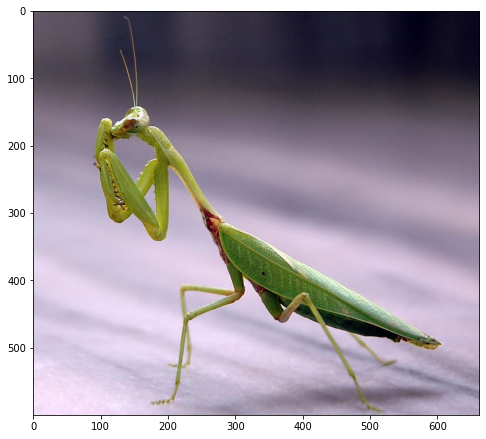

In [192]:
mantis_img_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/2/22/Praying_mantis_india.jpg/663px-Praying_mantis_india.jpg"
img = url_to_pil_img(mantis_img_url)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.show()

In [193]:
vgg11 = VGG11()
vgg11.eval()

VGG11(
  (pretrained_vgg11): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): ReLU(inplace=True)
      (15): MaxPool2d(ker

In [194]:

data = np.array(img)
data = np.rollaxis((data - 127.5)/127.5, 2, 0)

data = torch.from_numpy(data).reshape(1, 3, 600, 663).float()
prob = F.softmax(vgg11(data), dim=-1).squeeze()
orders = np.array(torch.argsort(prob, descending=True))
probs = prob.detach().numpy()
for k in range(10):
    print('%20s : %5f'%(dictionary[orders[k]], probs[orders[k]]))




              mantis : 0.411668
          leafhopper : 0.171959
         grasshopper : 0.117245
             cricket : 0.074083
            lacewing : 0.051920
       walking_stick : 0.032773
              cicada : 0.015114
                 ear : 0.008070
   sulphur_butterfly : 0.004903
   cabbage_butterfly : 0.003895


In [196]:
logits = vgg11(data)
pi = F.softmax(logits, dim=-1).squeeze()
mantis_idx = torch.argmax(pi).detach().item()
pi[mantis_idx].backward()

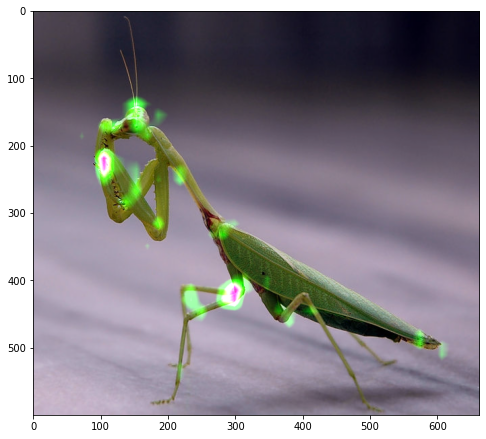

In [201]:
target_layer = 7
partial_derivative = vgg11.backward_cache[7 - target_layer][0].detach().squeeze()
forward_value = vgg11.forward_cache[target_layer][0].detach().squeeze()
my_grad_cam = (forward_value * partial_derivative).mean(dim=0)
my_grad_cam = F.relu(my_grad_cam)
original_grad_cam = (forward_value * partial_derivative.mean(dim=[1, 2]).reshape(-1, 1, 1)).mean(dim=0)
original_grad_cam = F.relu(original_grad_cam)
grad_cam = my_grad_cam / my_grad_cam.max()
grad_cam = np.uint8(grad_cam * 255)
heatmap = cv2.resize(grad_cam, (663, 600))
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
temp = heatmap
heatmap[:, :, 0] = temp[:, :, 2]
heatmap[:, :, 2] = temp[:, :, 0]
img = np.array(img)
superimposed_img = cv2.addWeighted(img, 0.8, heatmap, 0.9, 0)
plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img)
plt.show()

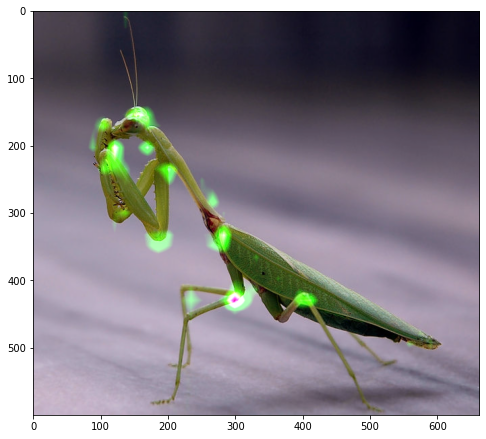

In [197]:
target_layer = 6
partial_derivative = vgg11.backward_cache[7 - target_layer][0].detach().squeeze()
forward_value = vgg11.forward_cache[target_layer][0].detach().squeeze()
my_grad_cam = (forward_value * partial_derivative).mean(dim=0)
my_grad_cam = F.relu(my_grad_cam)
original_grad_cam = (forward_value * partial_derivative.mean(dim=[1, 2]).reshape(-1, 1, 1)).mean(dim=0)
original_grad_cam = F.relu(original_grad_cam)
grad_cam = my_grad_cam / my_grad_cam.max()
grad_cam = np.uint8(grad_cam * 255)
heatmap = cv2.resize(grad_cam, (663, 600))
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
temp = heatmap
heatmap[:, :, 0] = temp[:, :, 2]
heatmap[:, :, 2] = temp[:, :, 0]
img = np.array(img)
superimposed_img = cv2.addWeighted(img, 0.8, heatmap, 0.9, 0)
plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img)
plt.show()

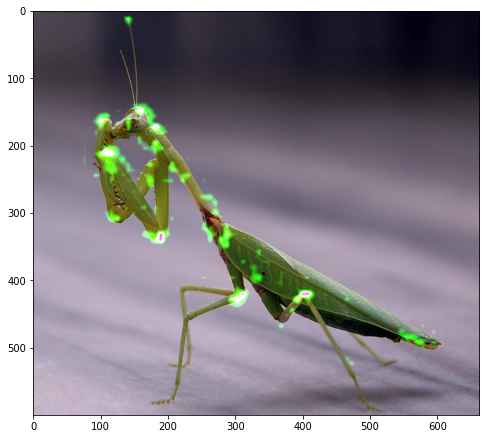

In [198]:
target_layer = 5
partial_derivative = vgg11.backward_cache[7 - target_layer][0].detach().squeeze()
forward_value = vgg11.forward_cache[target_layer][0].detach().squeeze()
my_grad_cam = (forward_value * partial_derivative).mean(dim=0)
my_grad_cam = F.relu(my_grad_cam)
original_grad_cam = (forward_value * partial_derivative.mean(dim=[1, 2]).reshape(-1, 1, 1)).mean(dim=0)
original_grad_cam = F.relu(original_grad_cam)
grad_cam = my_grad_cam / my_grad_cam.max()
grad_cam = np.uint8(grad_cam * 255)
heatmap = cv2.resize(grad_cam, (663, 600))
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
temp = heatmap
heatmap[:, :, 0] = temp[:, :, 2]
heatmap[:, :, 2] = temp[:, :, 0]
img = np.array(img)
superimposed_img = cv2.addWeighted(img, 0.8, heatmap, 0.9, 0)
plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img)
plt.show()

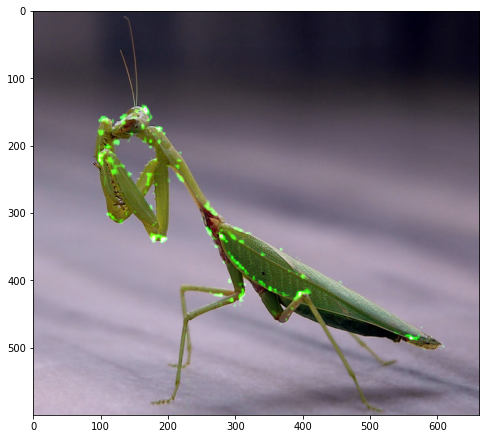

In [200]:
target_layer = 3
partial_derivative = vgg11.backward_cache[7 - target_layer][0].detach().squeeze()
forward_value = vgg11.forward_cache[target_layer][0].detach().squeeze()
my_grad_cam = (forward_value * partial_derivative).mean(dim=0)
my_grad_cam = F.relu(my_grad_cam)
original_grad_cam = (forward_value * partial_derivative.mean(dim=[1, 2]).reshape(-1, 1, 1)).mean(dim=0)
original_grad_cam = F.relu(original_grad_cam)
grad_cam = my_grad_cam / my_grad_cam.max()
grad_cam = np.uint8(grad_cam * 255)
heatmap = cv2.resize(grad_cam, (663, 600))
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
temp = heatmap
heatmap[:, :, 0] = temp[:, :, 2]
heatmap[:, :, 2] = temp[:, :, 0]
img = np.array(img)
superimposed_img = cv2.addWeighted(img, 0.8, heatmap, 0.9, 0)
plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img)
plt.show()

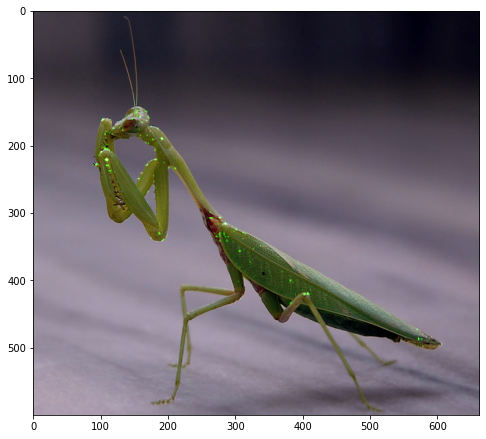

In [205]:
target_layer = 1
partial_derivative = vgg11.backward_cache[7 - target_layer][0].detach().squeeze()
forward_value = vgg11.forward_cache[target_layer][0].detach().squeeze()
my_grad_cam = (forward_value * partial_derivative).mean(dim=0)
my_grad_cam = F.relu(my_grad_cam)
original_grad_cam = (forward_value * partial_derivative.mean(dim=[1, 2]).reshape(-1, 1, 1)).mean(dim=0)
original_grad_cam = F.relu(original_grad_cam)
grad_cam = my_grad_cam / my_grad_cam.max()
grad_cam = np.uint8(grad_cam * 255)
heatmap = cv2.resize(grad_cam, (663, 600))
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
temp = heatmap
heatmap[:, :, 0] = temp[:, :, 2]
heatmap[:, :, 2] = temp[:, :, 0]
img = np.array(img)
superimposed_img = cv2.addWeighted(img, 0.7, heatmap, 0.99, 0)
plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img)
plt.show()